<a href="https://colab.research.google.com/github/ACCavalcantiAi/AI_PY_learning/blob/main/C%C3%B3pia_de_Minicurso_de_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependências

In [ ]:
# !pip install tensorflow==2.0.0-alpha0

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

%matplotlib inline

print(tf.__version__)

2.4.1


In [ ]:
#@title
def image_batch(batch, y_true, y_pred=None, labels=None, n_cols=10, figsize=(16,5)):
    plt.figure(figsize=figsize)
    
    y_pred = y_true if y_pred is None else y_pred
    labels = y_true if labels is None else labels
    n_rows = batch.shape[0] // n_cols + 1
    is_gray = (batch.ndim == 3)
    for img, true, pred, sub in zip(batch, y_true, y_pred, range(1, len(batch)+1)):
        plt.subplot(n_rows, n_cols, sub)
        plt.imshow(img.astype(np.uint8), cmap='gray' if is_gray else None)
        
        plt.title("[{}] {}".format(true, pred), color = 'green' if true == pred else 'red')
        plt.axis('off')
    plt.tight_layout()
    
def make_cubic(n_samples, x_min, x_max, a=1, b=0, c=0, d=0, noise=0.0, random_state=None):
    np.random.seed(random_state)
    x = np.linspace(x_min, x_max, n_samples)
    y = a*x**3 + b*x**2 + c*x + d + (2*noise*np.random.random(n_samples) - noise)
    return x.reshape(-1,1), y.reshape(-1,1)
    
def make_spiral(n_samples, n_class=2, radius=1, laps=1.0, noise=0.0, random_state=None):
    np.random.seed(random_state)
    x = np.zeros((n_samples * n_class, 2))
    y = np.zeros((n_samples * n_class))
    
    pi_2 = 2 * np.math.pi
    points = np.linspace(0, 1, n_samples)
    r = points * radius
    t = points * pi_2 * laps
    for label, delta_t in zip(range(n_class), np.arange(0, pi_2, pi_2/n_class)):
        random_noise = (2 * np.random.rand(n_samples) - 1) * noise
        index = np.arange(label*n_samples, (label+1)*n_samples)
        x[index] = np.c_[r * np.sin(t + delta_t) + random_noise,
                         r * np.cos(t + delta_t) + random_noise]
        y[index] = label
    return x, y.reshape(-1, 1)
  
def __softmax(x):
    exp = np.exp(x)
    return exp/np.sum(exp, axis=1, keepdims=True)

def __compute_meshgrid(x, y):
    x_min, x_max, y_min, y_max = x[:, 0].min(), x[:, 0].max(), x[:, 1].min(), x[:, 1].max()
    x1, x2 = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    x_mesh = np.array([x1.ravel(), x2.ravel()]).T
    return x1, x2, x_mesh

def plot_data_and_predictions_3d_in_2d(x, y, is_binary, nn, threshold=0.0, figsize=(12,6), s=15, cmap=plt.cm.viridis):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1, 2, 1)
    plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=s, cmap=cmap)

    if nn is not None:
      plt.subplot(1, 2, 2, sharex=ax, sharey=ax)

      x1, x2, x_mesh = __compute_meshgrid(x, y)
      y_mesh = nn.predict(x_mesh)
      y_mesh = np.where(y_mesh <= threshold, 0, 1) if is_binary else np.argmax(__softmax(y_mesh), axis=1)

      plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=s, cmap=cmap)
      plt.contourf(x1, x2, y_mesh.reshape(x1.shape), cmap=cmap, alpha=0.5)
    
def plot_history(hist):
    loss_train = hist['loss']
    loss_val = hist.get('val_loss', [])
    acc_train = hist.get('acc')
    acc_val = hist.get('val_acc', [])
    
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss_train, label='train')
    plt.plot(loss_val, label='val')
    plt.legend()
    plt.title('Loss')
    plt.xlabel('Epochs')
    
    if acc_train is not None:
      plt.subplot(1, 2, 2)
      plt.plot(acc_train, label='train')
      plt.plot(acc_val, label='val')
      plt.legend()
      plt.title('Accuracy')
      plt.xlabel('Epochs')

# Regressão

(100, 1) (100, 1)


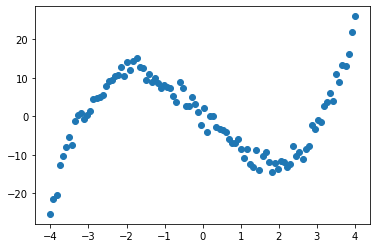

In [ ]:
x, y = make_cubic(n_samples=100, x_min=-4, x_max=4, a=1, b=0, c=-10, d=0, noise=3)

print(x.shape, y.shape)
plt.scatter(x, y)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 20,501
Trainable params: 20,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4/4 [==============================] - 3s 4ms/step - loss: 107.3076
Epoch 2/100
4/4 [==============================] - 0s 3ms/step - loss: 98.9634
Epoch 3/100
4/4 [==============================] - 0s 3ms/step - loss: 102.9552
Epoch 4/100

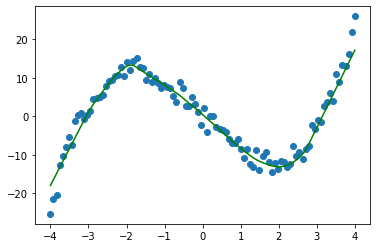

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation=tf.nn.relu, input_shape=(x.shape[1],)),
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=None)
])

model.summary()

model.compile(optimizer='adam', loss='mse')

hist = model.fit(x, y, batch_size=32, epochs=100, verbose=1)

plt.scatter(x, y)
plt.plot(x, model.predict(x), c='green')

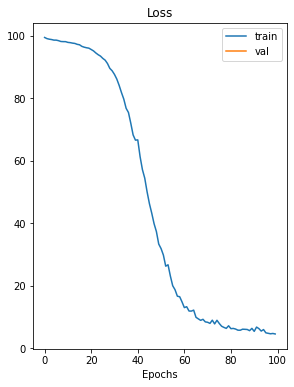

In [ ]:
plot_history(hist.history)

# Classificação Binária

(200, 2) (200, 1)


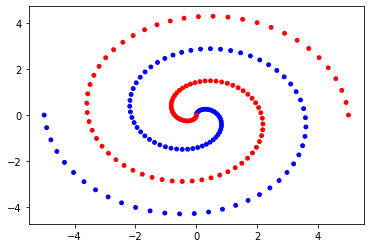

In [ ]:
x, y = make_spiral(n_samples=100, n_class=2, radius=5, laps=1.75)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 20,601
Trainable params: 20,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.6035
Epoch 2/100
7/7 [==============================] - 0s 3ms/step - loss: 0.6621 - accuracy: 0.6049
Epoch 3/100
7/7 [==============================] - 0s 

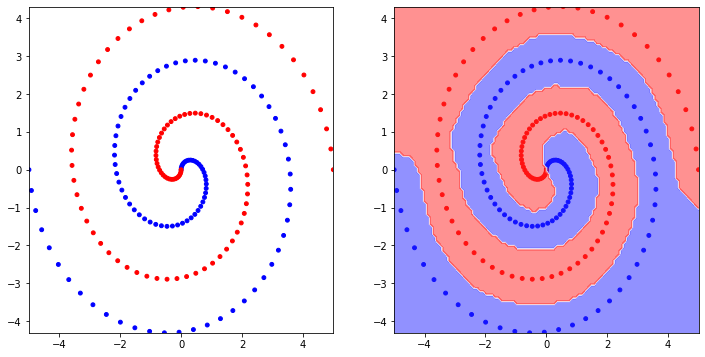

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation=tf.nn.relu, input_shape=(x.shape[1],)),
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

hist = model.fit(x, y, batch_size=32, epochs=100, verbose=1)

plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=model, threshold=0.5, cmap='bwr')

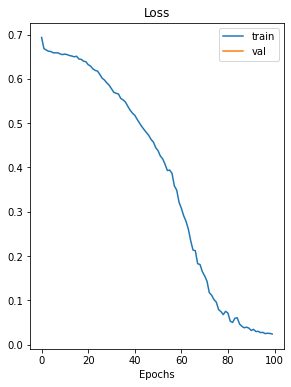

In [ ]:
plot_history(hist.history)

# Classificação Multiclasse

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


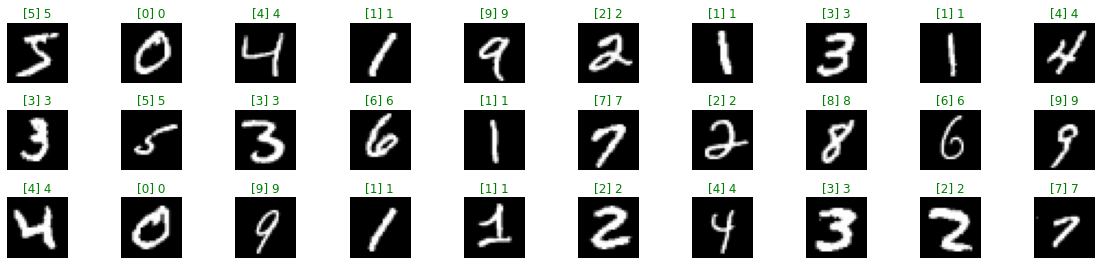

In [ ]:
image_batch(x_train[:30], y_train[:30])

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.summary()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train / 255, y_train, batch_size=32, epochs=1, validation_split=0.3)
model.evaluate(x_test / 255, y_test)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
313/313 [==============================] - 1s 2ms/step - loss: 0.1529 - accuracy: 0.9538


[0.1529005616903305, 0.9538000226020813]

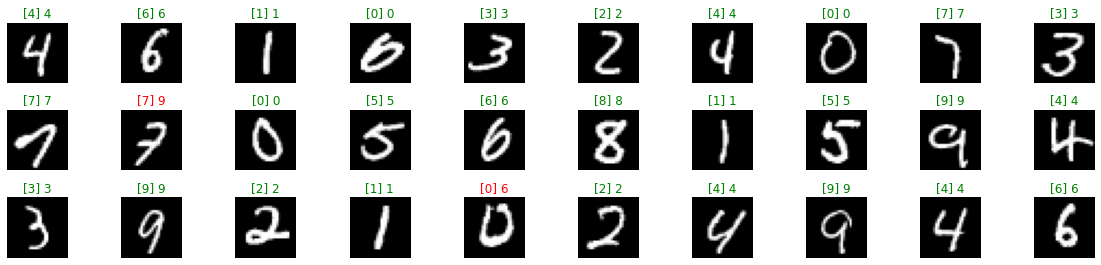

In [ ]:
random_idxs = np.random.choice(range(x_test.shape[0]), size=30)

y_pred = model.predict(x_test[random_idxs] / 255)

image_batch(x_test[random_idxs].squeeze(), y_test[random_idxs], np.argmax(y_pred, axis=1))

# Rede Convolucional

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = np.expand_dims(x_train, axis=-1), np.expand_dims(x_test, axis=-1)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.summary()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train / 255, y_train, batch_size=32, epochs=1, validation_split=0.3)
model.evaluate(x_test / 255, y_test)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                12560     
_________________________________________________________________
dense_11 (Dense)             (None, 10)               

[0.11426740884780884, 0.9671000242233276]

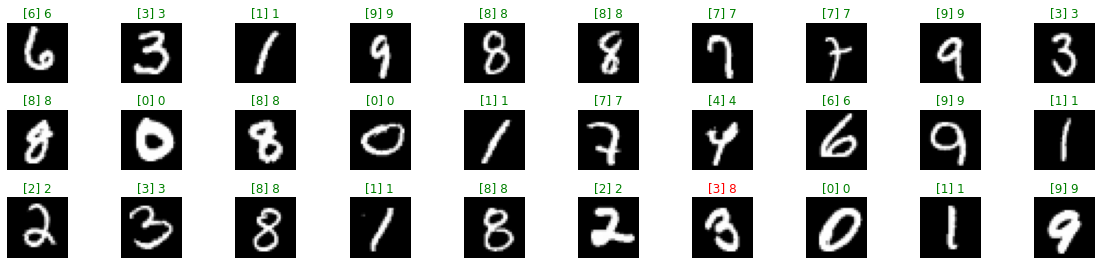

In [ ]:
random_idxs = np.random.choice(range(x_test.shape[0]), size=30)

y_pred = model.predict(x_test[random_idxs] / 255)

image_batch(x_test[random_idxs].squeeze(), y_test[random_idxs], np.argmax(y_pred, axis=1))